<a href="https://colab.research.google.com/github/AnniaBenitez/Cores_mod2/blob/main/Core_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [19]:
# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

os.listdir(path)

Path to dataset files: /root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1


['insurance.csv']

In [20]:
file_path = os.path.join(path, 'insurance.csv')

df = pd.read_csv(file_path)
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [22]:
stats = df.describe()

In [23]:
#outliers}
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = {col: detect_outliers(df, col) for col in ['age', 'bmi', 'children', 'charges']}
outliers

{'age': Empty DataFrame
 Columns: [age, sex, bmi, children, smoker, region, charges]
 Index: [],
 'bmi':       age     sex    bmi  children smoker     region      charges
 116    58    male  49.06         0     no  southeast  11381.32540
 286    46  female  48.07         2     no  northeast   9432.92530
 401    47    male  47.52         1     no  southeast   8083.91980
 543    54  female  47.41         0    yes  southeast  63770.42801
 847    23    male  50.38         1     no  southeast   2438.05520
 860    37  female  47.60         2    yes  southwest  46113.51100
 1047   22    male  52.58         1    yes  southeast  44501.39820
 1088   52    male  47.74         1     no  southeast   9748.91060
 1317   18    male  53.13         0     no  southeast   1163.46270,
 'children': Empty DataFrame
 Columns: [age, sex, bmi, children, smoker, region, charges]
 Index: [],
 'charges':       age     sex     bmi  children smoker     region      charges
 14     27    male  42.130         0    yes 

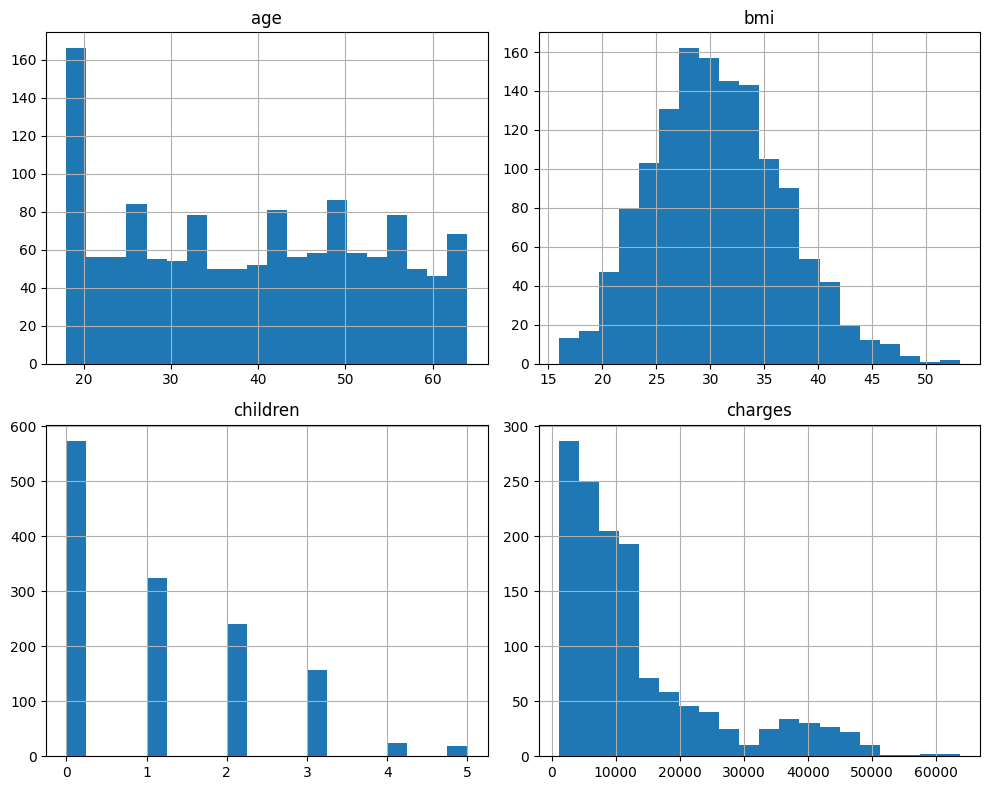

In [24]:
# Gráficos de distribución
df[['age', 'bmi', 'children', 'charges']].hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [26]:
# 1. Definir las columnas categóricas y numéricas
categorical_cols = ['sex', 'region']  # 'smoker' no debe estar aquí porque es la variable objetivo
numerical_cols = ['age', 'bmi', 'children', 'charges']

# 2. Imputación y transformación
# Imputadores
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Moda
numerical_imputer = SimpleImputer(strategy='mean')  # Media

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # Codificación binaria

# Escalado
scaler = StandardScaler()

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numerical_imputer), ('scaler', scaler)]), numerical_cols),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', one_hot_encoder)]), categorical_cols),
    ]
)

# 3. Dividir los datos en conjunto de entrenamiento y prueba (80/20)
X = df.drop(columns='smoker')  # 'smoker' es la variable objetivo y no debe estar en X
y = df['smoker']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modelos a evaluar
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier())
]

# 5. Evaluar modelos con validación cruzada
results = {}

# Crear el pipeline que incluye preprocesamiento y los modelos
for model_name, model in models:
    # Crear el pipeline específico para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Evaluación con validación cruzada (5 folds)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = cv_scores

# Mostrar resultados de validación cruzada
for model_name, cv_scores in results.items():
    print(f"{model_name}: Media de precisión = {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")

Logistic Regression: Media de precisión = 0.9514 +/- 0.0120
K-Nearest Neighbors: Media de precisión = 0.9374 +/- 0.0273
Decision Tree: Media de precisión = 0.9514 +/- 0.0152


In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint

# 1. Definir los hiperparámetros a optimizar para cada modelo
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularización para LogisticRegression
    'classifier__solver': ['lbfgs', 'liblinear']  # Diferentes algoritmos de optimización
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 10],  # Número de vecinos
    'classifier__weights': ['uniform', 'distance'],  # Tipo de ponderación
    'classifier__metric': ['minkowski', 'euclidean']  # Métrica de distancia
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],  # Profundidad máxima
    'classifier__min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
    'classifier__min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en hoja
}

# 2. Inicializar GridSearchCV y RandomizedSearchCV para cada modelo

# Logistic Regression GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))]),
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# KNN GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Decision Tree GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())]),
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# 3. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)

# Resultados de GridSearchCV
print("Resultados de GridSearchCV:")
print(f"Mejores parámetros para Logistic Regression: {grid_search_lr.best_params_}")
print(f"Mejores parámetros para K-Nearest Neighbors: {grid_search_knn.best_params_}")
print(f"Mejores parámetros para Decision Tree: {grid_search_dt.best_params_}")

# 4. Inicializar RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))]),
    param_distributions=param_grid_lr,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

random_search_knn = RandomizedSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    param_distributions=param_grid_knn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

random_search_dt = RandomizedSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())]),
    param_distributions=param_grid_dt,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# 5. Realizar la búsqueda de hiperparámetros con RandomizedSearchCV
random_search_lr.fit(X_train, y_train)
random_search_knn.fit(X_train, y_train)
random_search_dt.fit(X_train, y_train)

# Resultados de RandomizedSearchCV
print("\nResultados de RandomizedSearchCV:")
print(f"Mejores parámetros para Logistic Regression: {random_search_lr.best_params_}")
print(f"Mejores parámetros para K-Nearest Neighbors: {random_search_knn.best_params_}")
print(f"Mejores parámetros para Decision Tree: {random_search_dt.best_params_}")

# 6. Comparar los resultados de ambos métodos en términos de precisión en el conjunto de test
# Evaluar en el conjunto de test para ambos métodos

best_model_lr = grid_search_lr.best_estimator_
best_model_knn = grid_search_knn.best_estimator_
best_model_dt = grid_search_dt.best_estimator_

y_pred_lr = best_model_lr.predict(X_test)
y_pred_knn = best_model_knn.predict(X_test)
y_pred_dt = best_model_dt.predict(X_test)

print("\nResultados en el conjunto de prueba:")
print(f"Precisión de Logistic Regression con GridSearchCV: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precisión de K-Nearest Neighbors con GridSearchCV: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precisión de Decision Tree con GridSearchCV: {accuracy_score(y_test, y_pred_dt):.4f}")

# Comparar con RandomizedSearchCV
best_model_lr_random = random_search_lr.best_estimator_
best_model_knn_random = random_search_knn.best_estimator_
best_model_dt_random = random_search_dt.best_estimator_

y_pred_lr_random = best_model_lr_random.predict(X_test)
y_pred_knn_random = best_model_knn_random.predict(X_test)
y_pred_dt_random = best_model_dt_random.predict(X_test)

print("\nResultados en el conjunto de prueba con RandomizedSearchCV:")
print(f"Precisión de Logistic Regression con RandomizedSearchCV: {accuracy_score(y_test, y_pred_lr_random):.4f}")
print(f"Precisión de K-Nearest Neighbors con RandomizedSearchCV: {accuracy_score(y_test, y_pred_knn_random):.4f}")
print(f"Precisión de Decision Tree con RandomizedSearchCV: {accuracy_score(y_test, y_pred_dt_random):.4f}")


Resultados de GridSearchCV:
Mejores parámetros para Logistic Regression: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Mejores parámetros para K-Nearest Neighbors: {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Mejores parámetros para Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Resultados de RandomizedSearchCV:
Mejores parámetros para Logistic Regression: {'classifier__solver': 'lbfgs', 'classifier__C': 1}
Mejores parámetros para K-Nearest Neighbors: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 3, 'classifier__metric': 'euclidean'}
Mejores parámetros para Decision Tree: {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10}

Resultados en el conjunto de prueba:
Precisión de Logistic Regression con GridSearchCV: 0.9664
Precisión de K-Nearest Neighbors con GridSearchCV: 0.9590
Precisión de Decision Tree con GridSearchCV: 0.9627

Resultados en el conjunto de prueba con RandomizedSearchCV:
Precisión de Logistic Regression con RandomizedSearchCV: 0.9664
Precisión de K-Nearest Neighbors con RandomizedSearchCV: 0.9590
Precisión de Decision Tree con RandomizedSearchCV: 0.9590
